In [74]:
__author__ = 'nileshtrip'
import numpy as np
import math
import itertools
from collections import OrderedDict
import time

import pickle
import time
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
matplotlib.rc('text', usetex=True)

In [75]:
path="paper_plots"
if not os.path.exists(path):
    os.makedirs(path)

In [76]:
def MSE(err):

    err = np.array(err)
    MSE = np.mean(np.power(err,2))

    return MSE

In [77]:
def get_OM_data(reps, folder_path):
    
    results = OrderedDict()
    for data_file in [i for i in os.listdir(folder_path) if (".pickle" in i) and ("OM" in i)]:
        data = pickle.load(open(os.path.join(folder_path, data_file), "rb")) 
        n_list = data["n_list"]
        p_list = data["p_list"]
        s_list = data["s_list"]

        for p in p_list:
            for s in s_list:
                errors_fo1f = np.zeros(shape=(len(n_list), reps))
                errors_base = np.zeros(shape=(len(n_list), reps))
                for num, n in enumerate(n_list):
                    n=n[0]
                    for rep in range(reps):
                        fo1f=data[(p, n, s)][0][rep]
                        base=data[(p, n, s)][3][rep]
                        truth=data[(p, n, s)][4][rep]

                        errors_fo1f[num, rep] = MSE(fo1f-truth)
                        errors_base[num, rep] = MSE(base-truth)

                results[(p, s, data["main_reg"], data["n_splits"], data["train_dist"], data["test_dist"], "fo1f")] = errors_fo1f
                results[(p, s, data["main_reg"], data["n_splits"], data["train_dist"], data["test_dist"], "base")] = errors_base

        results["n_list"] = n_list
        results["p_list"] = data["p_list"]
        results["s_list"] = data["s_list"]
        
    return results

In [78]:
def error_bar_log(vec):
    
    _, num = vec.shape
    mu_log = np.log(np.mean(vec, axis=1))
    upper_log = np.log(np.mean(vec, axis=1) + 1*np.std(vec, axis=1)/math.sqrt(num) ) - mu_log
    lower_log = np.abs(mu_log - np.log(np.mean(vec, axis=1) - 1*np.std(vec, axis=1)/math.sqrt(num)))
    errs_log = np.vstack((lower_log, upper_log))
    
    return mu_log, errs_log

In [79]:
def plot_synthetic_cov_shift_CV(p, s, folder_path):
    
    dataOML = get_OM_data(reps=20, folder_path = folder_path)
    
    plt.close()
     
    n_splits=5
    train_dist=str(("normal", {}))
    test_dist=str(("normal+support_rank_one", {"support_scale" : 10.0}))
    
    t = "CVTrue"
    f = "CVFalse"
    
    OML_true, OML_true_std = error_bar_log(dataOML[(p, s, f, n_splits, train_dist, test_dist, "fo1f")])
    ridge_true, ridge_true_std = error_bar_log(dataOML[(p, s, f, n_splits, train_dist, test_dist, "base")])
    
    n_list = [i[0] for i in dataOML["n_list"]]
    p_list = dataOML["p_list"]
    s_list = dataOML["s_list"]
    
    w, h = figaspect(1.0)
    fig = plt.figure(figsize=(w,h))
    
    plt.errorbar(n_list, ridge_true, yerr=ridge_true_std, color="k", marker="x", label= r"Ridge ($\lambda$=CV)")
    plt.errorbar(n_list, OML_true, yerr=OML_true_std, color="r", marker="*", label= r"OM ($\lambda$=CV)")
            
    plt.legend(prop={'size': 14})
    plt.xlabel("Number of Sample Points ($n$)", fontsize=16)
    plt.ylabel(r"Log Average Prediction RMSRE", fontsize=16)
    plt.title(r"Distribution Shift in Cov. Matrix", fontsize=16)
    
    fname="synthetic_cov_shift_CV" +",s="+str(s)+",p="+str(p)+".pdf"
    folder_path="paper_plots/ridge_shift"
    plt.savefig(os.path.join(folder_path, fname), bbox_inches = "tight")
    plt.show()
    #time.sleep(2)
    
    return

In [80]:
def plot_synthetic_cov_shift_theory(p, s, folder_path):
    
    dataOML = get_OM_data(reps=20, folder_path = folder_path)
    plt.close()
     
    n_splits=5
    train_dist=str(("normal", {}))
    test_dist=str(("normal+support_rank_one", {"support_scale" : 10.0}))
    
    t = "CVTrue"
    f = "CVFalse"
    
    lasso_false, lasso_false_std = error_bar_log(dataOML[(p, s, f, n_splits, train_dist, test_dist, "base")])
    OML_false, OML_false_std = error_bar_log(dataOML[(p, s, f, n_splits, train_dist, test_dist, "fo1f")])
    
    n_list = [i[0] for i in dataOML["n_list"]]
    p_list = dataOML["p_list"]
    s_list = dataOML["s_list"]
    
    w, h = figaspect(1.0)
    fig = plt.figure(figsize=(w,h))
    
    plt.errorbar(n_list, lasso_false, yerr=lasso_false_std, color="k", marker="x", label= r"Ridge ($\lambda$=Theory)")
    plt.errorbar(n_list, OML_false, yerr=OML_false_std,  color="r", marker="*", label= r"OM ($\lambda$=Theory)")
            
    plt.legend(prop={'size': 14})
    plt.xlabel("Number of Sample Points ($n$)", fontsize=16)
    plt.ylabel(r"Log Average Prediction RMSRE", fontsize=16)
    plt.title(r"Distribution Shift in Cov. Matrix", fontsize=16)
    
    
    fname="synthetic_cov_shift_theory" +",s="+str(s)+",p="+str(p)+".pdf"
    folder_path="paper_plots/ridge_shift"
    plt.savefig(os.path.join(folder_path, fname), bbox_inches = "tight")
    plt.show()
    #time.sleep(2)
    
    return

In [81]:
folder_path="7-27-synthetic_ridge_expts"

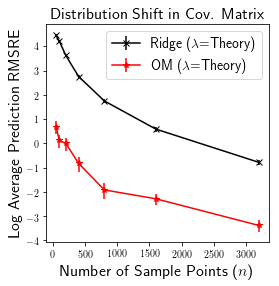

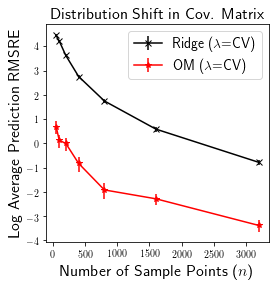

In [82]:
plot_synthetic_cov_shift_theory(p=200, s=200, folder_path=folder_path)
plot_synthetic_cov_shift_CV(p=200, s=200, folder_path=folder_path)

In [90]:
def plot_synthetic_mean_shift_CV(p, s, reps, folder_path):
    
    dataJM = get_JM_data(reps=reps, folder_path = folder_path)
    dataOML = get_OM_data(reps=reps, folder_path = folder_path)
    
    plt.close()
     
    n_splits=5
    train_dist=str(("normal", {}))
    test_dist=str(("normal+support_shift", {"scale" : 10.0}))
    
    t = "CVTrue"
    f = "CVFalse"
    
    OML_true, OML_true_std = error_bar_log(dataOML[(p, s, t, n_splits, train_dist, test_dist, "fo1f")])
    lasso_true, lasso_true_std = error_bar_log(dataOML[(p, s, t, n_splits, train_dist, test_dist, "base")])    
    
    
    n_list = [i[0] for i in dataOML["n_list"]]
    p_list = dataOML["p_list"]
    s_list = dataOML["s_list"]
    
    w, h = figaspect(1.0)
    fig = plt.figure(figsize=(w,h))
    
    plt.errorbar(n_list, lasso_true, yerr=lasso_true_std, color="k", marker="x", label= r"Ridge ($\lambda$=CV)")
    plt.errorbar(n_list, OML_true, yerr=OML_true_std, color="r", marker="*", label= r"OM ($\lambda$=CV)")
            
    plt.legend(prop={'size': 14})
    plt.xlabel("Number of Sample Points ($n$)", fontsize=16)
    plt.ylabel(r"Log Average Prediction RMSRE", fontsize=16)
    plt.title(r"Distribution Shift in Mean Vector", fontsize=16)
    
    
    fname="synthetic_mean_shift_CV"+",s="+str(s)+",p="+str(p)+".pdf"
    folder_path="paper_plots/ridge_shift"
    plt.savefig(os.path.join(folder_path, fname), bbox_inches = "tight")
    plt.show()
    #time.sleep(2)
    
    return

In [91]:
def plot_synthetic_mean_shift_theory(p, s, reps, folder_path):
    
    dataJM = get_JM_data(reps=reps, folder_path = folder_path)
    dataOML = get_OM_data(reps=reps, folder_path = folder_path)
     
    n_splits=5
    train_dist=str(("normal", {}))
    test_dist=str(("normal+support_shift", {"scale" : 10.0}))
    
    plt.close()
     
    t = "CVTrue"
    f = "CVFalse"
    
    OML_false, OML_false_std = error_bar_log(dataOML[(p, s, f, n_splits, train_dist, test_dist, "fo1f")])
    lasso_false, lasso_false_std = error_bar_log(np.abs(dataOML[(p, s, f, n_splits, train_dist, test_dist, "base")]))
        
    n_list = [i[0] for i in dataJM["n_list"]]
    p_list = dataJM["p_list"]
    s_list = dataJM["s_list"]
    
        
    w, h = figaspect(1.0)
    fig = plt.figure(figsize=(w,h))
    
    plt.errorbar(n_list, lasso_false, yerr=lasso_false_std, color="k", marker="x", label= r"Ridge ($\lambda$=Theory)")
    plt.errorbar(n_list, OML_false, yerr=OML_false_std,  color="r", marker="*", label= r"OM ($\lambda$=Theory)")
            
    plt.legend(prop={'size': 14})
    plt.xlabel("Number of Sample Points ($n$)", fontsize=16)
    plt.ylabel(r"Log Average Prediction RMSRE", fontsize=16)
    #plt.title("1st-order OML on "+"TrainDist," + str(train_dist) + "TestDist," + str(test_dist) + "ShiftType" + str(shift_type) + "(p,s)="+str(p)+","+str(s))
    plt.title(r"Distribution Shift in Mean Vector", fontsize=16)
    
    fname="synthetic_mean_shift_theory"+",s="+str(s)+",p="+str(p)+".pdf"
    folder_path="paper_plots/ridge_shift"
    plt.savefig(os.path.join(folder_path, fname), bbox_inches = "tight")
    plt.show()
    #time.sleep(2)
    
    return

In [92]:
folder_path="7-27-synthetic_ridge_expts"

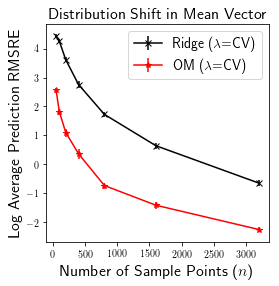

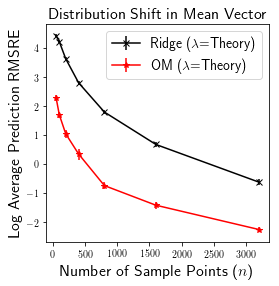

In [93]:
plot_synthetic_mean_shift_CV(p=200, s=200, reps=20, folder_path=folder_path)
plot_synthetic_mean_shift_theory(p=200, s=200, reps=20, folder_path=folder_path)